In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch

Font size is set to 10


In [14]:
tmp = torch.randn(4, 5)
print(tmp)
import torch.nn as nn 
m = nn.Dropout(p=0.8)
m(tmp)

tensor([[-1.4704,  2.2759, -0.4129,  0.5404, -2.1503],
        [ 0.9798, -2.0047, -0.7257, -0.5614,  0.5318],
        [ 1.2784, -0.5035,  0.6980, -1.1854,  0.4011],
        [ 0.3313, -1.9166,  0.7864, -0.2253,  1.0782]])


tensor([[ -7.3518,   0.0000,  -0.0000,   0.0000,  -0.0000],
        [  0.0000, -10.0233,  -0.0000,  -0.0000,   0.0000],
        [  0.0000,  -0.0000,   0.0000,  -0.0000,   2.0054],
        [  1.6564,  -0.0000,   0.0000,  -0.0000,   0.0000]])

In [ ]:
df_mapping_locs, _ = cdu.load_names_unique_locs()
df_mapping_locs.head()

,tuple_coords,footprintWKT,count,name_loc
0,"(-2.165105, 50.956811)","POLYGON((-2.17221 50.9523,-2.17221 50.96132,-2...",53410,UKBMS_loc-0000
1,"(-2.646667, 50.775285)","POLYGON((-2.6537 50.77075,-2.6537 50.77982,-2....",51809,UKBMS_loc-0001
2,"(-0.828484, 50.888106)","POLYGON((-0.8357 50.88368,-0.8357 50.89253,-0....",48596,UKBMS_loc-0002
3,"(-1.966038, 50.59722)","POLYGON((-1.97311 50.59273,-1.97311 50.60171,-...",46522,UKBMS_loc-0003
4,"(-0.22994099999999998, 52.409243)","POLYGON((-0.23747 52.40486,-0.23747 52.41363,-...",44130,UKBMS_loc-0004


In [ ]:
df_per_loc = cdu.load_species_dataset()
df_per_loc.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-7.824283, 54.259247)",0.0,0.696970,0.242424,0.333333,0.272727,0.060606,0.121212,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,UKBMS_loc-1044
1,"(-7.457325, 54.15933)",0.0,0.419355,0.387097,0.354839,0.000000,0.064516,0.000000,0.870968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,UKBMS_loc-1420
2,"(-6.949025, 54.883646)",0.0,0.363636,0.409091,0.045455,0.000000,0.090909,0.000000,0.818182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,UKBMS_loc-0979
3,"(-6.753205, 55.169256)",0.0,0.448276,0.413793,0.034483,0.448276,0.034483,0.034483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,UKBMS_loc-0925
4,"(-6.405594, 55.228089)",0.0,0.718750,0.187500,0.375000,0.437500,0.093750,0.500000,0.218750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,UKBMS_loc-0962


In [140]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='top_20',
                              zscore_im=True, 
                              augment_image=False, mode='val')



Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping top 20 species with most observations.


In [4]:
ds.weights_values

array([2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 ,
       2.67555721, 2.60601106, 2.37230982, 2.13612016, 2.11151002,
       1.93717747, 1.90750588, 1.86342024, 1.66866389, 1.38788758,
       1.37239898, 1.18117534, 1.10216876, 1.00703108, 1.        ])

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# import itertools
# for i, (species1, species2) in enumerate(itertools.combinations(ds.species_list, 2)):
#     sns.jointplot(data=ds.df_presence, x=species1, y=species2, ax=ax[i])
#     ax[i].set_title(f'{species1} vs {species2}')


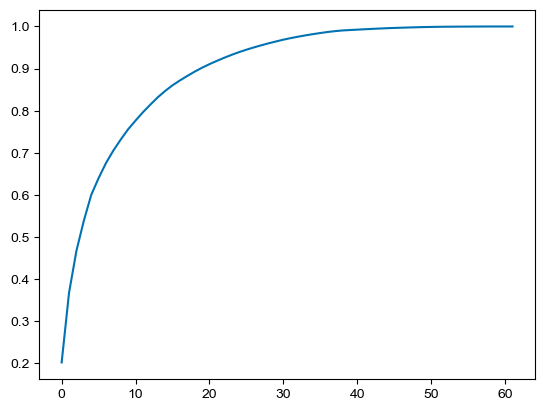

In [ ]:
pres_val = ds.df_presence[ds.species_list].values
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(pres_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


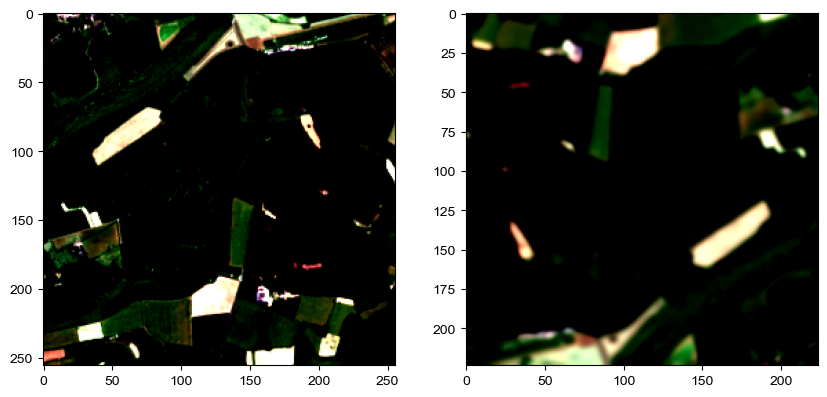

In [180]:
im, pres = ds[0]
ds.mode = 'train'
im_transformed = ds.transform_data(im)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im[:3, :, :].permute(1, 2, 0))
ax[1].imshow(im_transformed[:3, :, :].permute(1, 2, 0))

## Results 

- v16 pred / n layers 1 
- v17 pred incl enc / n layers 2 
- v18 pecl / n layers 1 
- v19 post-pecl pred / n layers 1
- v20: pred incl enc / n_layers 2 / freeze True 
- v21: pred / n layers 2 / freeze True 
- v22: pred incl enc / n layers 2 / freeze False 

Findings:
- PECL doesn't work atm (v19 v20). Why does post-pecl pred not work though (V20)? Does passing on models in general work?
- Freezing resnet doesn't matter for pred_incl_enc (v20 v22)
- Pred incl enc works better than pred only (v22 vs v21, v17 vs v16)
- All same plateau .. Check for a trivial solution? (Different random seed.. )

 NON-weighted (B)CE:
- v114: top 20, pretrained False??, BCE, 1 layer
- v116: top 20, seco, BCE, 1 layer
- v117: top 20, seco, BCE, 2 layer
- v118: All species, Seco, BCE, 2 layer mlp pred
- v119: top 20, imagenet, BCE, 2 layer [WORSE than seco]
- v120: top 20, imagenet, BCE, 2 layer, NOT frozen [=> train loss lower but 
val loss higher] 
- v121: pecl
- v122: top 20, seco, CE, 2 layer, [converged solution much further from mean preds than with BCE (0.2 vs 0.03). BCE loss also increases. ]
- v124: top 20, seco, BCE, 2 layer, 32 enc channels [everything above 64 channels.] [Same as 64, just tiny bit slower to converge. ]
- v125: top 20, seco, BCE, 2 layer, 128 channels. [ bit quicker than 64, higher top10 acc]
- v126: top 20, seco, BCE, 2 layer, 256 channels. [again bit quicker than 128]
- v127: top 20, seco, BCE, 2 layer, 512 channels. [slightly quicker than 256/similar]
- v128: top 20, seco, CE, 2 layer, 512 channels 
- v130, top 20, seco, BCE, 2 layer, 512 channels [identical to v127] 
- v131: top 20, seco,  CE, 2 layer, 512 => also identical to CE. 

- v136: top 20, seco, weighted BCE, 2 layer, 512. [faster convergence than non-weighted BCE. ]
- v137: top 20, seco, weighted BCE, 2 layer, 256, lr 1e3
- v138: all sp, seco, weighted BCE, 2 layer, 256, 1e-3 [just ended up predicting the mean.!]
- v139: all sp, seco,  BCE, 2 layer, 246, 1e-3

- v158: PECL (from v139), all, lr 1e-5, batch 64, knn=5, freeze_resnet=False, freeze_resnet_fc_loaded_model=True, epochs=20
- v159: pred_incl_enc (from v158), lr 3e-4, BCE, freeze_resnet=True, 

- v162: PECL (from v139), all, lr 1e-5, batch 64, knn=2, freeze_resnet=False, freeze_resenet_fc=True, epoch=30. 

Trying contrastive regularisation (pred_and_pecl): same as v139 otherwise [EXCEPT FOR LR WHICH IS 1e-3 ON v139]. LR 3e-4, batchsize 64.
- v164 alpha ratio=0.02/0.01?
- v165 alpha ratio=0.05
- v166 alpha ratio=0.1
- v167 alpha ratio=0.2
- v168 alpha ratio=0.5
- v169: alpha ratio=1 
- v170: alpha ratio=0 
- v171: alpha ratio=0, lr=1e-3 [is be identical to v139]
- v172: alpha ratio=0.1, lr=1e-3
- v173, alpha ratio=0.5 [FAILED]
- v174, alpha ratio=0.2
- v175, alpha ratio=0.5
- v176, alpha ratio=0.1, knn=5

Ran 16 models:
Conclusions: top_20 slightly higher acc than all (expected I guess). BCE > wBCE. PECL CR > alpha=0. 5~=2 knn. PECL CR no effect on wBCE because ratio too low. 
--------
- 177, iteration 1: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 42, 0, True)
- 178, iteration 2: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 42, 0.1, True)
- 180, iteration 3: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 42, 0, True)
- 181, iteration 4: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 42, 0.1, True)
- 182, iteration 5: ('pred_and_pecl', 'all', 256, 0.001, 64, 5, True, 'bce', 'seco', 42, 0, True)
- 183, iteration 6: ('pred_and_pecl', 'all', 256, 0.001, 64, 5, True, 'bce', 'seco', 42, 0.1, True)
- 184, iteration 7: ('pred_and_pecl', 'all', 256, 0.001, 64, 5, True, 'weighted-bce', 'seco', 42, 0, True)
- 185, iteration 8: ('pred_and_pecl', 'all', 256, 0.001, 64, 5, True, 'weighted-bce', 'seco', 42, 0.1, True)

- 186, iteration 9: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 2, True, 'bce', 'seco', 42, 0, True)
- 187, iteration 10: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 2, True, 'bce', 'seco', 42, 0.1, True)
- 189, iteration 11: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 42, 0, True)
- 190, iteration 12: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 42, 0.1, True)
- 191, iteration 13: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 5, True, 'bce', 'seco', 42, 0, True)
- 192, iteration 14: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 5, True, 'bce', 'seco', 42, 0.1, True)
- 193, iteration 15: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 5, True, 'weighted-bce', 'seco', 42, 0, True)
- 194, iteration 16: ('pred_and_pecl', 'top_20', 256, 0.001, 64, 5, True, 'weighted-bce', 'seco', 42, 0.1, True)
-------------------
- 196, repeat of it 178 but with RANDOMCROP and JITTER. 
- 197, repeat of it 178 but with RANDOMCROP only
- v198, repeat of it 178 but with RANDOMCROp and JITTER and BLUR

New series, all with just RANDOMCROP. different seeds. All using the same train/val split. 
---------
- 199, iteration 1: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 19, 0, True)
- 200, iteration 2: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 19, 0.1, True)
- 201, iteration 3: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 86, 0, True)
- 202, iteration 4: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 86, 0.1, True)
- 203, iteration 5: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 17, 0, True)
- 204, iteration 6: ('pred_and_pecl', 'all', 256, 0.001, 32, 2, True, 'bce', 'seco', 17, 0.1, True)
- 205, iteration 7: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 0, True)
- 206, iteration 8: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 0.1, True)
- 207, iteration 9: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 0, True)
- 208, iteration 10: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 0.1, True)
- 209, iteration 11: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 0, True)
- 210, iteration 12: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 0.1, True)
- 211, iteration 13: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 19, 0, True)
- 212, iteration 14: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 19, 0.1, True)
- 213, iteration 15: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 86, 0, True)
- 214, iteration 16: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 86, 0.1, True)
- 215, iteration 17: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 17, 0, True)
- 216, iteration 18: ('pred_and_pecl', 'all', 256, 0.001, 128, 2, True, 'bce', 'seco', 17, 0.1, True)
-------------------

Combinations will be run in this order:
---------
- 217, iteration 1: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 0.5, True)
- 218, iteration 2: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 1, True)
- iteration 3: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 2, True)
- iteration 4: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 4, True)
- iteration 5: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 19, 8, True)
- iteration 6: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 0.5, True)
- iteration 7: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 1, True)
- iteration 8: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 2, True)
- iteration 9: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 4, True)
- iteration 10: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 86, 8, True)
- iteration 11: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 0.5, True)
- iteration 12: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 1, True)
- iteration 13: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 2, True)
- iteration 14: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 4, True)
- iteration 15: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'bce', 'seco', 17, 8, True)
- iteration 16: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 19, 0.5, True)
- iteration 17: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 19, 1, True)
- iteration 18: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 19, 2, True)
- iteration 19: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 19, 4, True)
- iteration 20: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 19, 8, True)
- iteration 21: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 86, 0.5, True)
- iteration 22: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 86, 1, True)
- iteration 23: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 86, 2, True)
- iteration 24: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 86, 4, True)
- iteration 25: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 86, 8, True)
- iteration 26: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 17, 0.5, True)
- iteration 27: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 17, 1, True)
- iteration 28: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 17, 2, True)
- 235, iteration 29: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 17, 4, True)
- 236, iteration 30: ('pred_and_pecl', 'all', 256, 0.001, 64, 2, True, 'weighted-bce', 'seco', 17, 8, True)
-------------------

- 260: try out with drop out 0.2, seed 42, alpha 0.1, knn=5.


In [3]:
final_model, _ = pem.train_pecl(
                    model=None,
                    training_method='pred_and_pecl', 
                    pecl_distance_metric='softmax',
                    species_process='all',
                    use_class_weights=True,
                    n_enc_channels=256, lr=1e-3,
                    n_epochs_max=100, batch_size=64, 
                    pecl_knn=5, pecl_knn_hard_labels=True,
                    freeze_resnet=True, alpha_ratio_loss=0.1,
                    n_layers_mlp_resnet=1, n_layers_mlp_pred=2,
                    pred_train_loss='bce',
                    pretrained_resnet='seco',
                    # pretrained_resnet=False,
                    # save_model=True,
                    use_lr_scheduler=True,
                    normalise_embedding='l2')

Seed set to 42


Pytorch version is 2.2.0.dev20231210
Found 1336 out of 1455 images in the image folder.
Shuffling data.
Using dropout.
Loaded 62 class weights on cpu.
Class weights now on mps:0.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (mps), used: True


Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.
Freezing all but last layer: True, last layer: False.
Freezing prediction model: False.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name             | Type       | Params
------------------------------------------------
0 | resnet           | ResNet     | 11.3 M
1 | prediction_model | Sequential | 81.7 K
------------------------------------------------
213 K     Trainable params
11.2 M    Non-trainable params
11.4 M    Total params
45.571    Total estimated model params size (MB)


-- Starting training at 2024-03-03 19:36:19.956644 with 100 epochs.
Using ReduceLROnPlateau scheduler.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


-- Finished training at 2024-03-03 19:57:41.175604.
Stats saved as PECL-ImEn_2024-03-03-1957_vnum-260_stats.pkl at /Users/t.vanderplas/models/PECL/stats/PECL-ImEn_2024-03-03-1957_vnum-260_stats.pkl


DataSetImagePresence(image_folder=/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/2019/m-06-09/, presence_csv=/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv)

In [ ]:
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')

post_pecl_model, _ = pem.train_pecl(
                    model=tmp_model,
                    freeze_resnet_fc_loaded_model=True,
                    training_method='pecl', 
                    pecl_distance_metric='softmax',
                    species_process='all', 
                    use_class_weights=True,
                    n_enc_channels=256, lr=1e-5,
                    n_epochs_max=30, batch_size=64, 
                    pecl_knn=2, pecl_knn_hard_labels=True,
                    freeze_resnet=False, 
                    pred_train_loss='weighted-bce',
                    pretrained_resnet='seco',
                    use_lr_scheduler=True)

final_model, _ = pem.train_pecl(
                    model=post_pecl_model,
                    training_method='pred_incl_enc', 
                    pecl_distance_metric='softmax',
                    species_process='all', 
                    use_class_weights=False,
                    n_enc_channels=256, lr=3e-4,
                    n_epochs_max=50, batch_size=64, 
                    pecl_knn=5, pecl_knn_hard_labels=True,
                    freeze_resnet=True, 
                    pred_train_loss='bce',
                    pretrained_resnet='seco',
                    use_lr_scheduler=True)

   

In [16]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=True, mode='val')

# train_ds, val_ds = ds.split_into_train_val(filepath='../../content/split_indices_2024-02-29-2154.pth')

Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.


In [87]:
mean_rates.val_loss_dict

{'mse': [0.013739305548369884],
 'bce': [0.44239291548728943],
 'top_5': [0.6094594597816467],
 'top_10': [0.6722972989082336],
 'top_20': [0.8459459543228149]}

In [27]:
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')


Loaded ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [28]:
final_model.hparams

"alpha_ratio_loss":     0
"batch_size_used":      64
"class_weights":        [  3.82071028   1.15143138   1.79151517   1.40139592   1.16680263
   1.60272979   2.24695048   1.           1.56423264  14.03818548
   1.           1.63056096   3.60679577   1.9910918    1.
   2.18817912   2.35124265   3.37123227   1.77314859   1.
  13.8519716    2.9351655    9.46909952   2.68709974  28.45987897
   9.2660317    2.33401613   5.36075391  10.94260085  24.33373915
  77.00231845  27.5364122   84.25005866   9.32157163 166.61088985
  21.54195665 112.32013434  17.66389801  19.90016319  34.82811917
  81.55022219  20.160036    20.6972391   87.00020477 166.61088985
 166.61088985  53.87308403 166.61088985 166.61088985 166.61088985
 111.54760512 166.61088985 166.61088985 166.61088985 160.09783464
 166.61088985 166.61088985 166.61088985 166.61088985 166.61088985
 166.61088985 166.61088985]
"freeze_resnet":        True
"lr":                   0.0003
"n_bands":              4
"n_enc_channels":       256
"n_la

In [29]:
tmp_model.hparams

"class_weights":        [  3.82071028   1.15143138   1.79151517   1.40139592   1.16680263
   1.60272979   2.24695048   1.           1.56423264  14.03818548
   1.           1.63056096   3.60679577   1.9910918    1.
   2.18817912   2.35124265   3.37123227   1.77314859   1.
  13.8519716    2.9351655    9.46909952   2.68709974  28.45987897
   9.2660317    2.33401613   5.36075391  10.94260085  24.33373915
  77.00231845  27.5364122   84.25005866   9.32157163 166.61088985
  21.54195665 112.32013434  17.66389801  19.90016319  34.82811917
  81.55022219  20.160036    20.6972391   87.00020477 166.61088985
 166.61088985  53.87308403 166.61088985 166.61088985 166.61088985
 111.54760512 166.61088985 166.61088985 166.61088985 160.09783464
 166.61088985 166.61088985 166.61088985 166.61088985 166.61088985
 166.61088985 166.61088985]
"freeze_resnet":        True
"lr":                   0.001
"n_bands":              4
"n_enc_channels":       256
"n_layers_mlp_pred":    2
"n_layers_mlp_resnet":  1
"n_spec

In [17]:
tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=False,
                             pecl_distance_metric='softmax',
                             training_method='pecl',
                             pretrained_resnet='seco')

No class weights.
Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.
Freezing all but last layer: False, last layer: False.
Freezing prediction model: True.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
tmp_model.eval()
tmp_model.training

False

In [149]:
## check for all layers in resnet if they require grad

# tmp_model.resnet 
tmp_model.freeze_resnet_layers(freeze_all_but_last=False, freeze_last=True)
tmp_model.freeze_prediction_model(freeze=False)
for name, param in tmp_model.named_parameters():
    print(name, param.requires_grad)

resnet.conv1.weight True
resnet.bn1.weight True
resnet.bn1.bias True
resnet.layer1.0.conv1.weight True
resnet.layer1.0.bn1.weight True
resnet.layer1.0.bn1.bias True
resnet.layer1.0.conv2.weight True
resnet.layer1.0.bn2.weight True
resnet.layer1.0.bn2.bias True
resnet.layer1.1.conv1.weight True
resnet.layer1.1.bn1.weight True
resnet.layer1.1.bn1.bias True
resnet.layer1.1.conv2.weight True
resnet.layer1.1.bn2.weight True
resnet.layer1.1.bn2.bias True
resnet.layer2.0.conv1.weight True
resnet.layer2.0.bn1.weight True
resnet.layer2.0.bn1.bias True
resnet.layer2.0.conv2.weight True
resnet.layer2.0.bn2.weight True
resnet.layer2.0.bn2.bias True
resnet.layer2.0.downsample.0.weight True
resnet.layer2.0.downsample.1.weight True
resnet.layer2.0.downsample.1.bias True
resnet.layer2.1.conv1.weight True
resnet.layer2.1.bn1.weight True
resnet.layer2.1.bn1.bias True
resnet.layer2.1.conv2.weight True
resnet.layer2.1.bn2.weight True
resnet.layer2.1.bn2.bias True
resnet.layer3.0.conv1.weight True
resnet.l

In [9]:
train_dl, val_dl = _
# val_dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)


for i_batch, batch in enumerate(val_dl):
    im, label = batch 
    im = im.to(tmp_model.device)
    print(im.shape[0])
    im_enc = tmp_model.forward(im)
    pred = tmp_model.prediction_model(im_enc)
    assert pred.shape == label.shape, f'pred.shape={pred.shape}, label.shape={label.shape}'
    if i_batch == 1:
        break

64
64


Text(0.5, 25.52222222222222, 'embedding dimension')

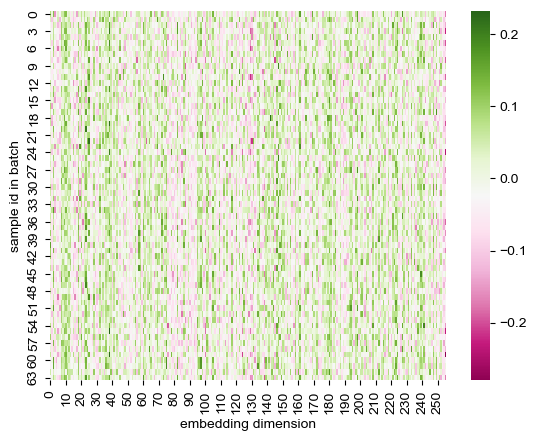

In [10]:
import seaborn as sns
sns.heatmap(im_enc.cpu().detach().numpy(), cmap='PiYG')    
plt.ylabel('sample id in batch')
plt.xlabel('embedding dimension')

(64, 62)
(64, 62) (64,)


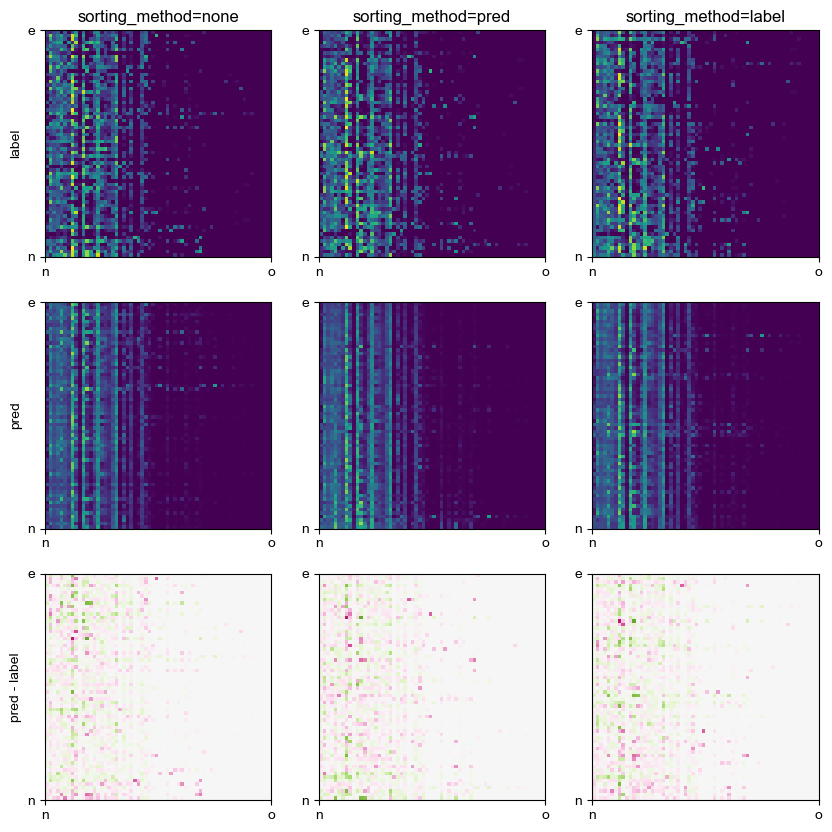

In [11]:
if type(pred) == torch.Tensor:
    if pred.device != 'cpu':
        pred = pred.cpu()
    pred = pred.detach().numpy()
if type(label) == torch.Tensor:
    if label.device != 'cpu':
        label = label.cpu()
    label = label.detach().numpy()
pred_zero_mean = pred - pred.mean(0)
label_zero_mean = label - label.mean(0)

assert pred.max() <= 1, f'pred.max()={pred.max()}'
assert pred.min() >= 0, f'pred.min()={pred.min()}'
assert label.max() <= 1, f'label.max()={label.max()}'
assert label.min() >= 0, f'label.min()={label.min()}'

# accuracy = 

print(label.shape)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for col, sorting_method in enumerate(['none', 'pred', 'label']):
    if sorting_method == 'none':
        idx = np.arange(label.shape[0])
    elif sorting_method == 'pred':
        idx = np.argsort(pred.sum(1))
    elif sorting_method == 'label':
        idx = np.argsort(label[:, 0])
        print(label.shape, idx.shape)
    
    ax[0, col].imshow(label[idx, :], vmin=0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[1, col].imshow(pred[idx, :], vmin=-0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[2, col].imshow(pred[idx, :] - label[idx, :], vmin=-1, vmax=1, cmap='PiYG', extent='none', interpolation='none')
    ax[0, col].set_title(f'sorting_method={sorting_method}')
    if col == 0:
        ax[0, col].set_ylabel('label')
        ax[1, col].set_ylabel('pred')
        ax[2, col].set_ylabel('pred - label')

In [12]:
np.mean(np.abs(pred - label)), np.mean(np.abs(label.mean(0)[None, :] - label))

(0.057485964, 0.06598642)

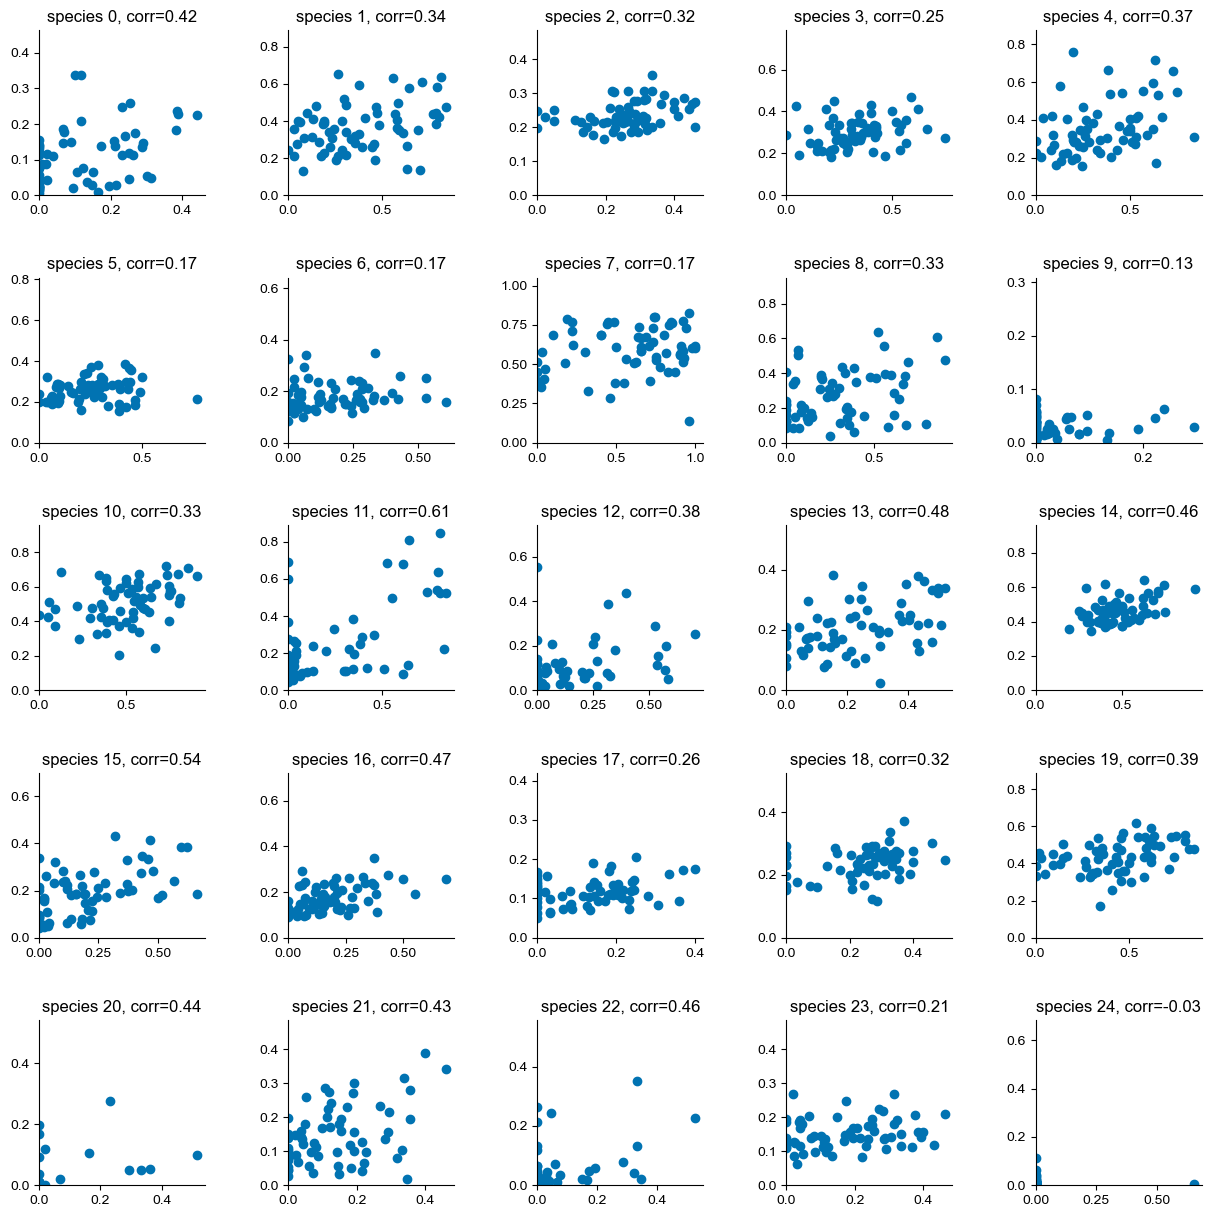

In [22]:
inds_species = np.arange(25)

n_species = len(inds_species)
n_cols = 5
n_rows = int(np.ceil(n_species / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 15),
                       gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, axi in enumerate(ax.flatten()):
    if i < n_species:
        axi.scatter(label[:, i], pred[:, i])
        rfv.despine(axi)
        rfv.equal_xy_lims(axi)
        rfv.set_min_lims_to_0(axi)
        corr = np.corrcoef(label[:, i], pred[:, i])[0, 1]
        axi.set_title(f'species {i}, corr={corr:.2f}') 
    else:
        axi.axis('off')

In [ ]:
# tmp_model = dict_models['pred_pca']
# tmp_model = im_enc
# tmp_model = pem.ImageEncoder.load_from_checkpoint("/Users/t.vanderplas/models/PECL/lightning_logs/version_2/checkpoints/best_checkpoint_val-epoch=45-val_loss=0.28-train_loss=0.15.ckpt")
# print(model.learning_rate)
tmp_model.eval()
single_data_sample = ds[0][0]
multi_data_sample = [ds[ii][0] for ii in range(10)]
multi_data_sample = torch.stack(multi_data_sample)
multi_label_sample = torch.stack([ds[ii][1] for ii in range(10)])
pred_enc = tmp_model.forward(multi_data_sample)
pred_pres = tmp_model.prediction_model(pred_enc)

print(pred_enc.shape, pred_pres.shape, multi_label_sample.shape)
tmp_model.top_k_accuracy(preds=pred_pres, target=multi_label_sample, k=20)

torch.Size([10, 32]) torch.Size([10, 20]) torch.Size([10, 20])


tensor(1.)

torch.Size([10, 32])


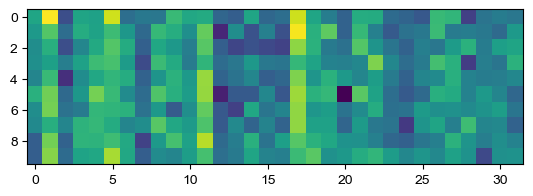

In [ ]:
tmp_pred = tmp_model.resnet(multi_data_sample)
print(tmp_pred.shape)
plt.imshow(tmp_pred.detach().numpy())
# torch.nn.functional.normalize(tmp_pred, p=1, dim=1).abs().sum(1)

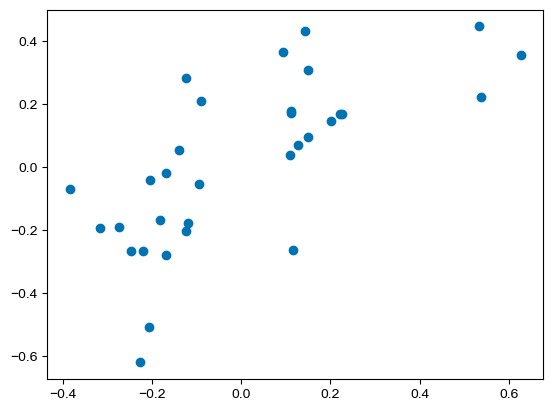

In [ ]:
plt.scatter(tmp_pred[0, :].detach().numpy(), tmp_pred[5, :].detach().numpy())

In [ ]:

target = torch.tensor([[.3, .1, .2, .1],[.1, 1, .3, .5]])
preds = torch.tensor([[0.1, 0.9, 0, 0], [0.2, 0.1, 0.5, 0.2]])
assert preds.shape[0] == target.shape[0], f'preds.shape[0] = {preds.shape[0]} != target.shape[0] = {target.shape[0]}'

loss_fn = torch.nn.BCELoss(reduction='none')
intermediate_loss = loss_fn(preds, target)
weights = torch.tensor([3.1, .2, 1.3, .4])
# print(intermediate_loss)
print(intermediate_loss)
final_loss = (intermediate_loss * weights)
final_loss.mean()

tensor([[ 0.7645,  2.0829, 20.0000, 10.0000],
        [ 0.3618,  2.3026,  0.6931,  0.9163]])


tensor(4.4545)

In [ ]:
n_samples = 6
n_classes = 5
## create two random torch matrices
# matrix 1
matrix1 = np.random.rand(n_samples, n_classes)
# matrix 2
matrix2 = np.random.rand(n_samples, n_classes)
matrix1 = torch.tensor(matrix1).float()
matrix2 = torch.tensor(matrix2).float()
assert matrix1.ndim == 2
tmp = torch.mm(matrix1, matrix1.t())

print(tmp.sum(0), tmp.sum(1))

tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796]) tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796])


In [ ]:
dist1 = pem.normalised_softmax_distance_batch(matrix1, exclude_diag_in_denominator=False, flatten=True)
dist2 = pem.normalised_softmax_distance_batch(matrix2, exclude_diag_in_denominator=False, flatten=True)

torch.Size([2, 15]) torch.Size([6, 6])
torch.Size([2, 15]) torch.Size([6, 6])


## Look at PECL pass
Look at:
- Distribution of s_ij values
- Distribution of w_ij values
- Steps of PECL pass

In [ ]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')
from torch.utils.data import DataLoader
train_dl = DataLoader(ds, batch_size=64, shuffle=False)

# tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
#                              pecl_distance_metric='softmax', n_enc_channels=256,
#                              training_method='pecl',
#                              pretrained_resnet='seco')
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')


tmp_model.eval() 


In [182]:
tmp_bool_use_dl = False

if tmp_bool_use_dl:
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(train_dl)):
            im, label = batch 
            
            im = im.to(tmp_model.device)
            im_enc = tmp_model.forward(im)
            pred = tmp_model.prediction_model(im_enc)
            
            if i_batch == 0:
                all_labels = label.clone() 
                all_im_encs = im_enc.clone()
                all_preds = pred.clone()
            else:
                all_labels = torch.cat([all_labels, label], dim=0)
                all_im_encs = torch.cat([all_im_encs, im_enc], dim=0)
                all_preds = torch.cat([all_preds, pred], dim=0)
            
            if i_batch == 0:
                break
else:
    all_labels = []
    for sample in tqdm(ds):
        all_labels.append(sample[1][None, :])
    all_labels = torch.cat(all_labels, dim=0)

100%|██████████| 1329/1329 [01:25<00:00, 15.55it/s]


In [183]:
import torch.nn.functional as F
all_labels_norm = F.normalize(all_labels, p=2, dim=1)
# all_preds_norm = F.normalize(all_preds, p=2, dim=1)

Number of species: 62, number of labels: 1329


<Axes: xlabel='cos similarity $s_{ij}$', ylabel='Number of pairs'>

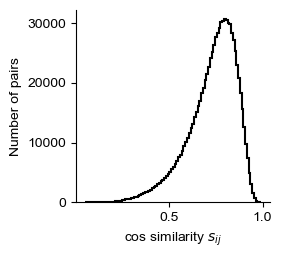

In [221]:
dvu.plot_distr_label_inner_prod(all_labels_norm.cpu().detach().numpy(),
                                save_fig=True) 

In [208]:
temperature = 1

all_labels_inner = pem.normalised_softmax_distance_batch(all_labels_norm, temperature=temperature, knn=None,
                                                      knn_hard_labels=False, inner_prod_only=True,
                                                      exclude_diag_in_denominator=False, flatten=False)
all_labels_inner = all_labels_inner.cpu().detach().numpy()

all_labels_sm = pem.normalised_softmax_distance_batch(all_labels_norm, temperature=temperature, knn=None,
                                                      knn_hard_labels=False, 
                                                      exclude_diag_in_denominator=False, flatten=False)

# all_im_encs_sm = pem.normalised_softmax_distance_batch(all_im_encs, temperature=temperature, knn=None,
#                                                         exclude_diag_in_denominator=False, flatten=False)
# all_im_encs_sm = all_im_encs_sm.cpu().detach().numpy()
all_labels_sm = all_labels_sm.cpu().detach().numpy()

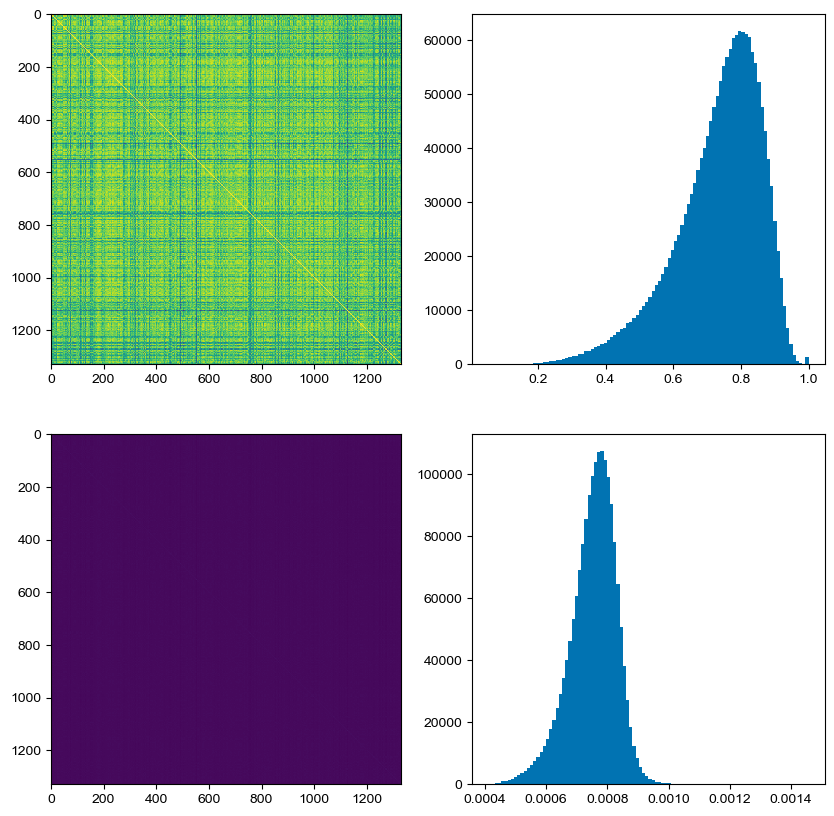

In [209]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# ax[0, 0].imshow(all_im_encs_sm, vmin=0, vmax=0.05, interpolation='none')
# ax[0, 1].hist(all_im_encs_sm.ravel(), bins=100)

ax[0, 0].imshow(all_labels_inner, vmin=0, vmax=1, interpolation='none')
ax[0, 1].hist(all_labels_inner.ravel(), bins=100)

ax[1, 0].imshow(all_labels_sm, vmin=0, vmax=0.03, interpolation='none')
ax[1, 1].hist(all_labels_sm.ravel(), bins=100);

In [123]:
inds_nz = np.where(all_labels_sm > 0)
all_labels_nz = all_labels_sm[inds_nz]
all_im_encs_nz = all_im_encs_sm[inds_nz]

# all_im_encs_nz.shape, all_labels_nz.shape
(-1 * np.log(all_im_encs_nz + 1e-8) * all_labels_nz).mean()

0.076133385

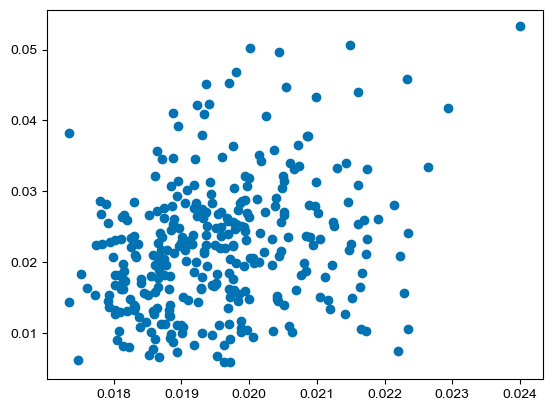

In [125]:
# plt.scatter(all_labels_sm.ravel(), all_im_encs_sm.ravel())
plt.scatter(all_labels_nz, all_im_encs_nz)

In [113]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))


# ax[0].hist(all_labels_sm, bins=100)
# ax[0].set_title('all_labels_sm')

# ax[1].hist(all_im_encs_sm, bins=100)
# ax[1].set_title('all_im_encs_sm')

# # ax[2].scatter(all_labels_sm, all_im_encs_sm)
# # ax[2].set_xlabel('all_labels_sm')
# # ax[2].set_ylabel('all_im_encs_sm')

In [8]:
# all_labels_norm_demeaned = all_labels_norm - all_labels_norm.mean(0)
# inner_prod_labels = torch.mm(all_labels_norm_demeaned, all_labels_norm_demeaned.t())
inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
## set diag to 0
inner_prod_labels = inner_prod_labels - torch.diag(inner_prod_labels.diag())

Got 63 nearest neighbours
[0.983 0.97  0.958 0.943 0.936]


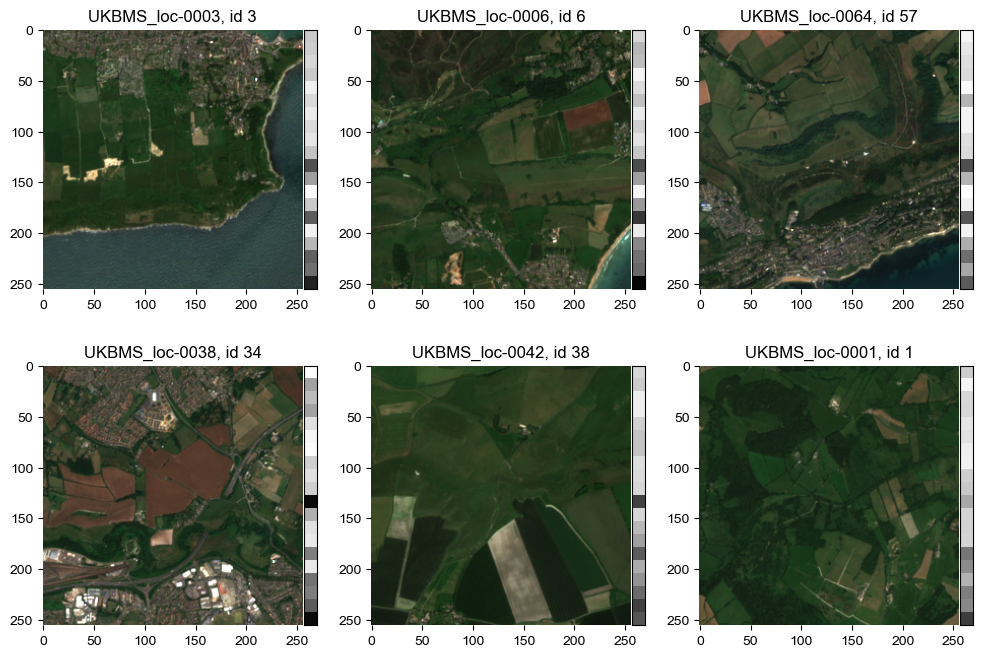

In [9]:

focal_ind = 3

## Using PECL Knn:
# inds_nz = torch.where(all_labels_sm > 0)
# inds_nn = inds_nz[1][inds_nz[0] == focal_ind]
# assert len(inds_nn) == 5, f'len(inds_nn)={len(inds_nn)}'

## Using inner product:
inds_nn = torch.where(inner_prod_labels[focal_ind, :] > 0.15)[0]
print(f'Got {len(inds_nn)} nearest neighbours')
## sort:
inds_nn = inds_nn[torch.argsort(inner_prod_labels[focal_ind, inds_nn], descending=True)]

inds_plot = [focal_ind] + inds_nn.tolist()
inds_plot = inds_plot[:6]
vals_inner = inner_prod_labels[focal_ind, inds_plot[1:]]
## round decimals:
vals_inner = np.round(vals_inner.numpy(), 3)
print(vals_inner)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel()

for i_ind, ind in enumerate(inds_plot):
    ds.plot_image(ind, ax=ax[i_ind])

(array([262., 408., 452., 390., 365., 370., 330., 321., 303., 263., 221.,
        140.,  99.,  62.,  37.,  23.,  16.,  11.,   8.]),
 array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
        0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
        0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
        0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
 <BarContainer object of 19 artists>)

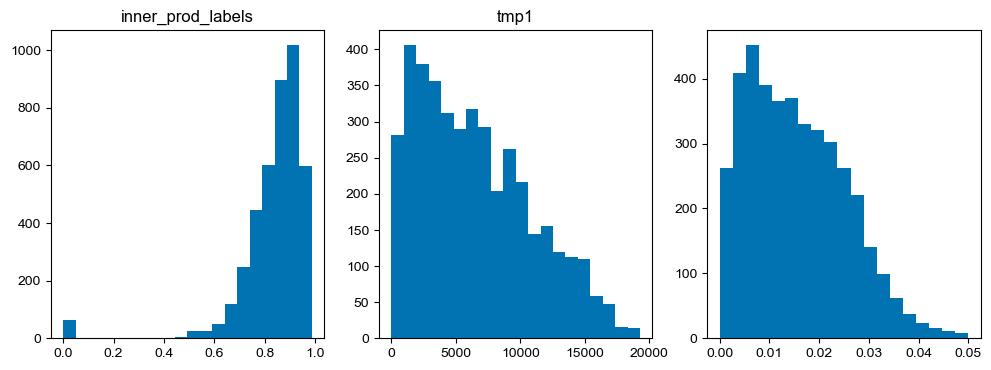

In [10]:
# inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
tmp1 = inner_prod_labels / 0.1 
tmp1 = torch.exp(tmp1)
tmp2 = torch.sum(tmp1, dim=1) - torch.diag(tmp1)
tmp3 = tmp1 / tmp2[:, None]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(inner_prod_labels.numpy().ravel(), bins=20)
ax[0].set_title('inner_prod_labels')

ax[1].hist(tmp1.numpy().ravel(), bins=20)
ax[1].set_title('tmp1')

ax[2].hist(tmp3.numpy().ravel(), bins=np.linspace(0, 0.05, 20))


In [213]:
tmp_model.pecl_knn = None

In [270]:
tmp_ims, tmp_preds = tmp_model.pecl_loss(im_enc=all_im_encs[:64, :], pres_vec=all_labels[:64, :])

In [271]:
tmp_inds = torch.where(tmp_preds > 0)

In [287]:
# tmp_ims = tmp_ims[tmp_inds]
(-1 * torch.log(tmp_ims) * tmp_preds[tmp_inds]).mean()

tensor(5.7158)

In [285]:
import torch.nn as nn 
nn.CrossEntropyLoss(reduction='none')(tmp_ims, tmp_preds[tmp_inds])

tensor(1846.0205)